# HBV Calibration

## Setup and Data Preparation

In [22]:
#some general python and eWaterCycle libraries need to be imported
%matplotlib inline
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display
import xarray as xr
from scipy.stats import wasserstein_distance

# Niceties
from rich import print
from tqdm import tqdm


# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
from ewatercycle.forcing import sources
from ewatercycle.models import HBV

# Optional: Data Assimilation
# If not installed, uncomment below to install
# !pip install ewatercycle-da
from ewatercycle_DA import DA

## Choose region and time period

In [2]:
# name of the catchment
basin_name = "FR000119"

# defining dates for calibration
experiment_start_date = "2013-11-26T00:00:00Z"
experiment_end_date = "2019-12-31T00:00:00Z"

#Define Catchment Area
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"

#check
catchment = gpd.read_file(shapefile_path)
catchment = catchment.to_crs(epsg=3035)
catchment["area_km2"] = catchment.geometry.area / 1e6  
basin_area = catchment["area_km2"].sum()
#catchment.plot()

In [3]:
# Location forcing files in home directory
forcing_path = Path.home() / "forcing" / "FR000119"/"ERA5"
forcing_path.mkdir(parents=True, exist_ok=True)

## Generate ERA 5 Forcing

In [4]:
# Option one: generate forcing:
#ERA5_forcing = sources["LumpedMakkinkForcing"].generate(
    #dataset="ERA5",
    #start_time=experiment_start_date,
    #end_time=experiment_end_date,
    #shape=shapefile_path,
#)

# Option two: Load generated (merged) data
forcing_dir = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrep5yvtlv4f_20250525_104347/work/diagnostic/script")
ERA5_forcing = sources["LumpedMakkinkForcing"].load(directory=forcing_dir)

## Defining historical data from eStreams
The original CSV file had some formatting and encoding issues—like strange quotation marks and all the data crammed into a single column—which made it impossible to load with the usual pandas.read_csv() method. To work around this, I used a custom parser to manually extract the dates and discharge values.

In [5]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Discharge (m³/s)")
Q_obs = discharge_series[experiment_start_date:experiment_end_date]

## Ensemble Initialization and Parameter Sampling

In [6]:
# Define HBV parameter bounds and names
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
p_min = np.array([0.0,  0.2,   40.0,  0.5,   0.001,   1.0,   0.01,  0.0001,  0.01])
p_max = np.array([8.0,  1.0,  800.0,  4.0,   0.3,    10.0,   0.1,   0.01,   10.0])

n_particles = 1000  # ensemble size

# Sample random parameters for each particle within bounds
parameters = np.zeros((len(param_names), n_particles))
for j in range(len(param_names)):
    parameters[j, :] = np.random.uniform(p_min[j], p_max[j], size=n_particles)

In [7]:
# Create ensemble and initialize each member with HBV model and unique parameters
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()  # set up the ensemble environment

# Prepare setup arguments for each particle (each gets its parameter set)
setup_kwargs_list = [{'parameters': parameters[:, i]} for i in range(n_particles)]

# Initialize all ensemble members with the HBVLocal model, forcing data, and parameters
ensemble.initialize(model_name=["HBVLocal"] * n_particles,
                    forcing=[ERA5_forcing] * n_particles,
                    setup_kwargs=setup_kwargs_list) 

# Choose a reference model for time tracking
ref_model = ensemble.ensemble_list[0].model

# Generate config file with first parameter set
config_file, _ = ref_model.setup(parameters=parameters[:, 0])

# Initialize model
ref_model.initialize(config_file)

In [8]:
# deleta all unnescessary files, Watchout with this!!!
# import shutil
# from pathlib import Path

# # Search for all folders starting with "hbvlocal_"
# work_dir = Path(".")
# folders = [f for f in work_dir.glob("hbvlocal_*") if f.is_dir()]

# # Delete them all
# for folder in folders:
#     print(f"Delete: {folder}")
#     shutil.rmtree(folder)

## Running the Ensemble Simulation

In [9]:
# Determine number of time steps in the simulation period
n_timesteps = int((ref_model.end_time - ref_model.start_time) / ref_model.time_step)

time_index = []           # list to store timestamps for each time step
ensemble_Q_outputs = []   # list to store discharge arrays for each time step

for step in range(n_timesteps):
    # Record current model time
    current_time = pd.Timestamp(ref_model.time_as_datetime.date())
    time_index.append(current_time)
    
    # Advance all models by one time step and collect their discharge values
    ensemble.update()  # update all ensemble members by one step
    Q_values = np.array(ensemble.get_value("Q")).flatten()  # discharge of all particles
    Q_values_m3s = Q_values * basin_area * 1000 / 86400 #convert to m3/s
    ensemble_Q_outputs.append(Q_values_m3s)

# Finalize the ensemble to release resources
ensemble.finalize()

# Convert collected outputs to a DataFrame for convenience
Q_array = np.array(ensemble_Q_outputs)        # shape: (n_timesteps, n_particles)
df_ensemble = pd.DataFrame(
    data=Q_array, 
    index=pd.DatetimeIndex(time_index), 
    columns=[f"particle_{i}" for i in range(n_particles)]
)

In [10]:
print(df_ensemble.shape)
print(df_ensemble.head())

(2555, 1000)

particle_0  particle_1  particle_2  particle_3  particle_4  \
2013-01-01    0.000133    0.001074    0.000000    0.000019    0.009395   
2013-01-02    0.000750    0.165741    0.000000    0.000543    1.547100   
2013-01-03    0.002288    0.651365    0.000000    0.002467    3.059775   
2013-01-04    0.005352    1.813330    0.000121    0.006615    6.845264   
2013-01-05    0.010856    4.018713    0.002455    0.015151   14.414025   

            particle_5  particle_6  particle_7  particle_8  particle_9  ...  \
2013-01-01    0.000000    0.000110    0.000000    0.000000    0.000000  ...   
2013-01-02    0.000000    0.000637    0.000083    0.000000    0.000003  ...   
2013-01-03    0.000000    0.001620    0.000415    0.000000    0.000017  ...   
2013-01-04    0.000003    0.003059    0.065561    0.000107    0.000089  ...   
2013-01-05    0.010144    0.005752    0.388709    0.018123    0.000448  ...   

            particle_990  particle_991  particle_992  particle_993  \
2013-01-01      0.000000      0.000086      0.000000      0.000000   
2013-01-02      0.000002      0.002603      0.000000      0.000284   
2013-01-03      0.000011      0.009870      0.000000      0.001415   
2013-01-04      0.000291      0.030803      0.000155      0.004403   
2013-01-05      0.007610      0.086675      0.189676      0.012863   

            particle_994  particle_995  particle_996  particle_997  \
2013-01-01      0.000000      0.000004      0.000000      0.002787   
2013-01-02      0.000060      0.000109      0.000011      0.020981   
2013-01-03      0.000298      0.000417      0.000054      0.040552   
2013-01-04      0.005306      0.002054      0.000200      0.089140   
2013-01-05      0.038553      0.009020      0.000600      0.196775   

            particle_998  particle_999  
2013-01-01      0.001328      0.000116  
2013-01-02      0.004865      0.016685  
2013-01-03      0.008382      0.064874  
2013-01-04      0.015993      0.189085  
2013-01-05      0.026600      0.566925  

[5 rows x 1000 columns]

## Defining the Calibration Objective

In [11]:
def calibration_objective(simulated_series: pd.Series, observed_series: pd.Series) -> float:
    """
    Compute the calibration objective for a single model run by comparing 
    simulated and observed discharge series. The objective combines:
      - RMSE on days with observed flow < 500 m³/s
      - EMD between distributions of drought event durations
      - EMD between distributions of drought event cumulative deficits
    Lower values indicate a better fit to observations.
    """
    # Align simulated series with observed series index
    sim = simulated_series.loc[observed_series.index]
    obs = observed_series

    # 1. RMSE for days with observed discharge < 500 m³/s
    low_flow_mask = obs < 500.0
    if low_flow_mask.sum() == 0:
        rmse_low_flow = 0.0  # no low-flow days, no penalty
    else:
        errors = sim[low_flow_mask] - obs[low_flow_mask]
        rmse_low_flow = np.sqrt(np.mean(errors**2))

    # 2. EMD between drought event durations
    # Identify drought events in observed and simulated series
    obs_droughts = droughts(obs, basin_name="obs", q_crit=500)
    sim_droughts = droughts(sim, basin_name="sim", q_crit=500)
    # Convert to DataFrame for
    obs_droughts_df = pd.DataFrame(obs_droughts)
    sim_droughts_df = pd.DataFrame(sim_droughts)
    # Extract durations of each drought event
    obs_durations = obs_droughts_df["Duration (days)"].values
    sim_durations = sim_droughts_df["Duration (days)"].values
    # Compute EMD (Wasserstein distance) between duration distributions
    emd_duration = wasserstein_distance(obs_durations, sim_durations)

    # 3. EMD between drought cumulative deficits
    # Extract the maximum cumulative deficit of each drought event (most negative deficit)
    obs_deficits = obs_droughts_df["Max Cumulative Deficit (m3/s)"].values
    sim_deficits = sim_droughts_df["Max Cumulative Deficit (m3/s)"].values
    #Cconvert negative values to positive magnitudes for comparison
    obs_deficits = -obs_deficits
    sim_deficits = -sim_deficits
    # Compute EMD between deficit distributions
    emd_deficit = wasserstein_distance(obs_deficits, sim_deficits)

    # Combine the three components into a single score
    total_score = rmse_low_flow + emd_duration + emd_deficit
    return total_score

In [12]:
print("Q_obs index sample:", Q_obs.index[:3])
print("df_ensemble index sample:", df_ensemble.index[:3])

Q_obs index sample: DatetimeIndex(['2013-11-26 00:00:00+00:00', '2013-11-27 00:00:00+00:00',
               '2013-11-28 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

df_ensemble index sample: DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03'], dtype='datetime64[ns]', 
freq=None)

## Evaluating Performance and Selecting the Best Parameter Set

In [16]:
from critical_days_module import droughts

Exported functions to: critical_days_module.py


In [17]:
# Evaluate objective for each ensemble member
scores = []

# Same datetime-index
Q_obs.index = Q_obs.index.normalize()
Q_obs.index = Q_obs.index.tz_localize(None)

# Slice only the overlap 
Q_obs_aligned = Q_obs.loc[df_ensemble.index.min():df_ensemble.index.max()]

for i in range(n_particles):
    sim_series = df_ensemble[f"particle_{i}"]

    if sim_series is None or sim_series.empty:
        print(f"Skipping particle_{i} (empty output)")
        scores.append(np.inf)  # Assign a bad score
        continue

    # Use the correct observation series (make sure Q_obs exists and matches in index)
    score = calibration_objective(sim_series, Q_obs_aligned)
    scores.append(score)

scores = np.array(scores)
best_index = np.argmin(scores)              # index of minimum objective value
best_score = scores[best_index]             # lowest score
best_params = parameters[:, best_index]     # parameter set corresponding to best score

print(f"Best score: {best_score:.3f} (part {best_index})")

Best score: 288.407 (part 300)

In [18]:
print("Number of scores:", len(scores))
print("First 5 scores:", scores[:5])

Number of scores: 1000

First 5 scores: [29639.46220161  4294.76507016  2567.24789118  6757.59880409
  1442.155647  ]

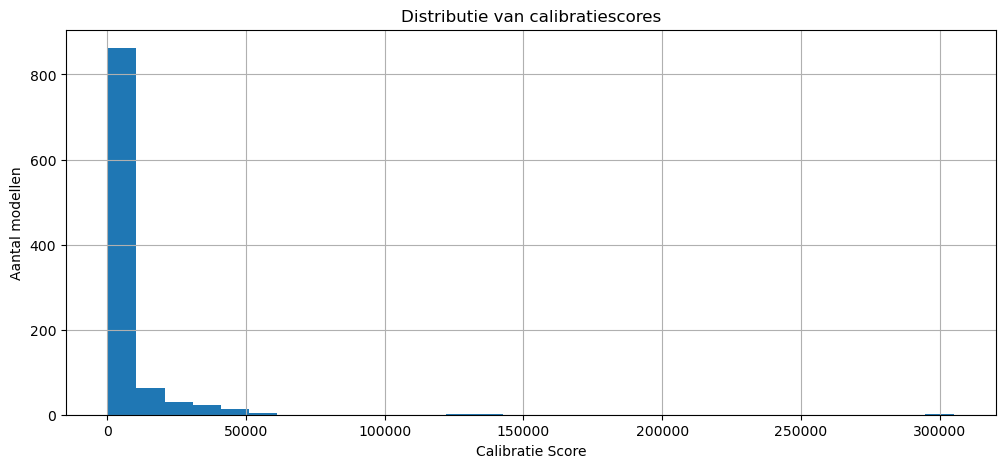

Best score: 288.407 at particle index: 300

In [19]:
# Histogram of scores
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(scores, bins=30)
plt.title("Distributie van calibratiescores")
plt.xlabel("Calibratie Score")
plt.ylabel("Aantal modellen")
plt.grid(True)
plt.show()

# Print best score
print(f"Best score: {best_score:.3f} at particle index: {best_index}")

## Outputting the Optimal Parameters

In [20]:
# Print the best score and parameter
print(f"Best objective score: {best_score:.4f}")
best_params_list = [round(val, 4) for val in best_params]
print("par_0 =", best_params_list)
print("param_names =", param_names)

Best objective score: 288.4069

par_0 =
[5.2023, 0.7735, 514.3276, 2.1726, 0.1879, 6.8253, 0.017, 0.0099, 2.9328]

param_names =
['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

In [23]:
# Print best score
print(f"Best objective score: {best_score:.4f}")

# Round best parameters
best_params_list = [round(val, 4) for val in best_params]

# Define parameter descriptions (must match param_names)
param_descriptions = [
    "Maximum intensity",
    "Coefficient of evaporation",
    "Field capacity",
    "Shape coefficient",
    "Maximum percolation rate",
    "Time lag",
    "Fast run-off parameter",
    "Slow run-off parameter",
    "Degree-day factor"
]

# Build DataFrame
df_params = pd.DataFrame({
    "Parameter": param_names,
    "Description": param_descriptions,
    "Value": best_params_list
})

# Reset index and drop it for clean display
df_params.index = [""] * len(df_params)

# Display the styled table
display(df_params.style.set_table_styles([
    {"selector": "th", "props": [("font-weight", "bold")]}
]))

Best objective score: 288.4069

,Parameter,Description,Value
,Imax,Maximum intensity,5.202300
,Ce,Coefficient of evaporation,0.773500
,Sumax,Field capacity,514.327600
,Beta,Shape coefficient,2.172600
,Pmax,Maximum percolation rate,0.187900
,Tlag,Time lag,6.825300
,Kf,Fast run-off parameter,0.017000
,Ks,Slow run-off parameter,0.009900
,FM,Degree-day factor,2.932800
